/Users/shashwatshahi/Desktop/Fall 2024 Assignments/CSYE 7380 Gen AI/Mid-Project/env/lib/python3.12/site-packages/pinecone/data/index.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
Discovering subpackages in _NamespacePath(['/Users/shashwatshahi/Desktop/Fall 2024 Assignments/CSYE 7380 Gen AI/Mid-Project/env/lib/python3.12/site-packages/pinecone_plugins'])
Looking for plugins in pinecone_plugins.inference
Installing plugin inference into Pinecone
Found 8091 vectors in index
Fetching vectors: 100%|████████████████████| 8091/8091 [01:13<00:00, 110.46it/s]
Successfully retrieved 50 feature vectors


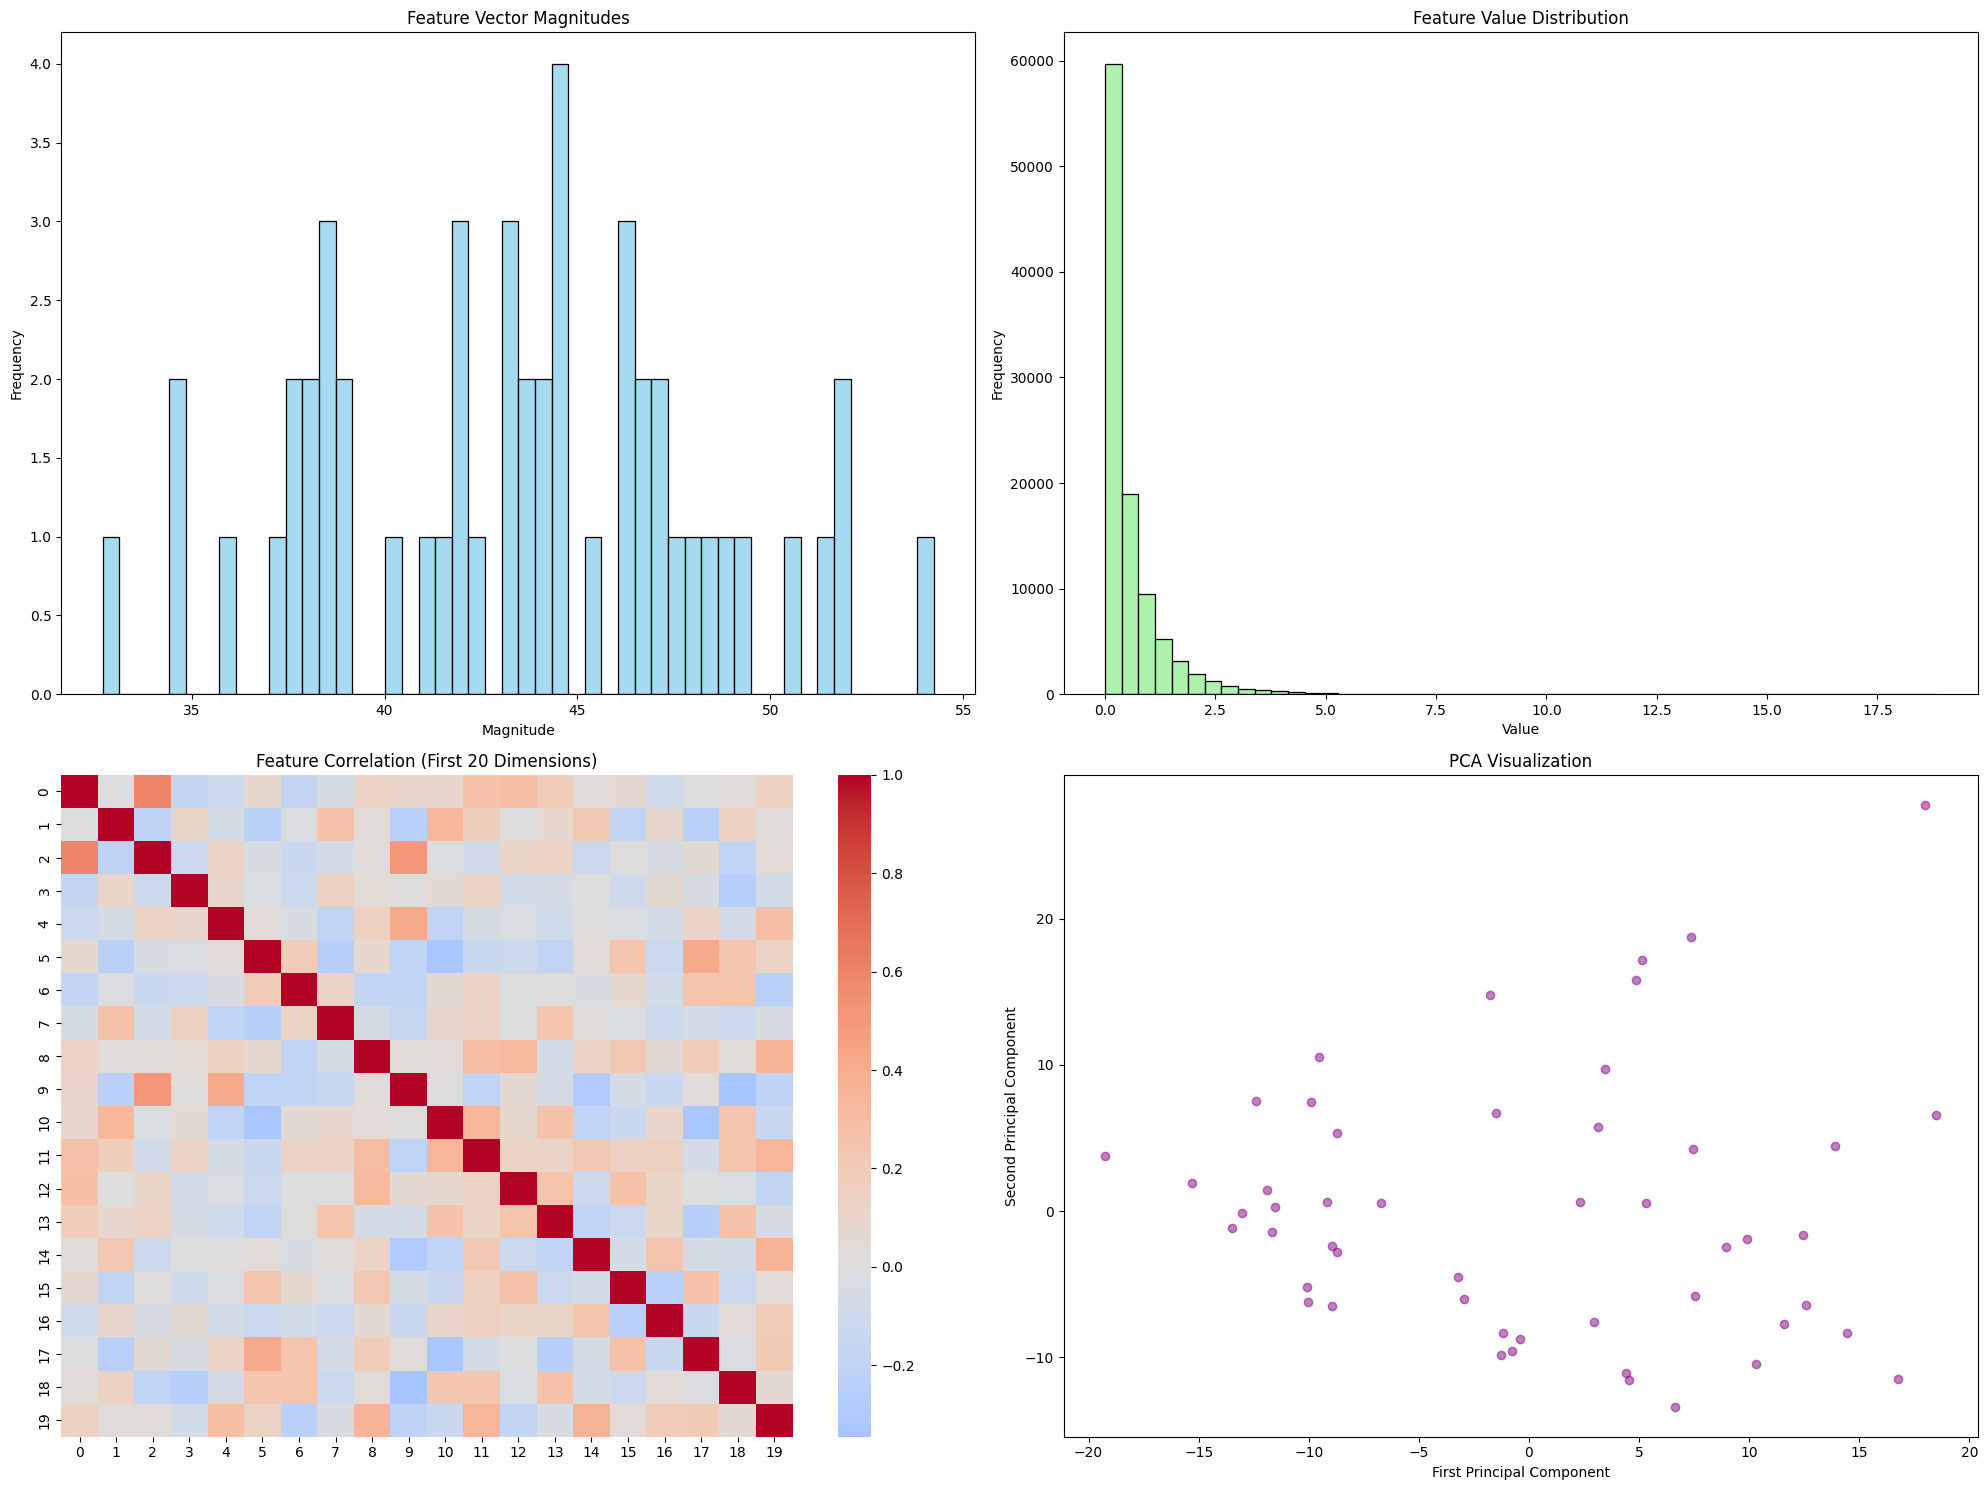


Feature Statistics:
Number of vectors: 50
Feature dimension: 2048
Mean magnitude: 43.3764
Std magnitude: 4.9321
Mean value: 0.5471
Std value: 0.7945


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from pinecone import Pinecone
import yaml
import logging
from sklearn.decomposition import PCA

def fetch_features_from_pinecone(api_key, index_name, chunk_size=50):
    """Fetch features from Pinecone index using new API"""
    try:
        # Initialize Pinecone
        pc = Pinecone(api_key=api_key)
        index = pc.Index(index_name)
        
        # Get total vector count
        stats = index.describe_index_stats()
        total_vectors = stats.total_vector_count
        logging.info(f"Found {total_vectors} vectors in index")
        
        # Create a dummy query vector (2048-D for ResNet50)
        query_vector = np.zeros(2048).tolist()
        features = {}
        
        # Use tqdm with position=0 and leave=True for single line progress
        with tqdm(total=total_vectors, desc="Fetching vectors", 
                 position=0, leave=True, ncols=80) as pbar:
            for i in range(0, total_vectors, chunk_size):
                try:
                    # Query a chunk of vectors
                    response = index.query(
                        vector=query_vector,
                        top_k=min(chunk_size, total_vectors - i),
                        include_values=True,
                        include_metadata=False
                    )
                    
                    if response and response.matches:
                        for match in response.matches:
                            features[match.id] = np.array(match.values)
                    
                    # Update progress bar
                    pbar.update(len(response.matches))
                
                except Exception as e:
                    logging.warning(f"Error fetching chunk: {str(e)}")
                    continue
        
        logging.info(f"Successfully retrieved {len(features)} feature vectors")
        return features
    
    except Exception as e:
        logging.error(f"Error fetching features: {str(e)}")
        return None

def visualize_features(features):
    """Create visualizations of the feature distributions"""
    if not features:
        logging.error("No features to visualize")
        return
    
    # Convert features to numpy array
    feature_array = np.array(list(features.values()))
    
    plt.figure(figsize=(20, 15))
    
    # 1. Feature Magnitude Distribution
    plt.subplot(2, 2, 1)
    magnitudes = np.linalg.norm(feature_array, axis=1)
    sns.histplot(magnitudes, bins=50, color='skyblue')
    plt.title('Feature Vector Magnitudes', fontsize=12)
    plt.xlabel('Magnitude')
    plt.ylabel('Frequency')
    
    # 2. Feature Value Distribution
    plt.subplot(2, 2, 2)
    sns.histplot(feature_array.flatten(), bins=50, color='lightgreen')
    plt.title('Feature Value Distribution', fontsize=12)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    
    # 3. Feature Correlation Heatmap
    plt.subplot(2, 2, 3)
    corr_matrix = np.corrcoef(feature_array[:, :20].T)
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
    plt.title('Feature Correlation (First 20 Dimensions)', fontsize=12)
    
    # 4. PCA Visualization
    plt.subplot(2, 2, 4)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(feature_array)
    plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5, c='purple')
    plt.title('PCA Visualization', fontsize=12)
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nFeature Statistics:")
    print(f"Number of vectors: {len(features)}")
    print(f"Feature dimension: {feature_array.shape[1]}")
    print(f"Mean magnitude: {np.mean(magnitudes):.4f}")
    print(f"Std magnitude: {np.std(magnitudes):.4f}")
    print(f"Mean value: {np.mean(feature_array):.4f}")
    print(f"Std value: {np.std(feature_array):.4f}")

def main():
    # Setup logging with minimal format
    logging.basicConfig(
        level=logging.INFO,
        format='%(message)s'
    )
    
    try:
        # Load configuration
        with open('config.yaml', 'r') as file:
            config = yaml.safe_load(file)
        
        # Fetch features
        features = fetch_features_from_pinecone(
            api_key=config['pinecone']['api_key'],
            index_name=config['pinecone']['index_name'],
            chunk_size=50
        )
        
        if features:
            visualize_features(features)
        else:
            logging.error("Failed to retrieve features from Pinecone")
            
    except Exception as e:
        logging.error(f"Error in main: {str(e)}")

if __name__ == "__main__":
    main()